### Предобработка данных, не вошедшая в проект

Загрузка необходимых библиотек:

In [1]:
import re
import nltk
import torch
import gensim 
import numpy as np
import pandas as pd
import transformers
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt


from tqdm import tqdm
from tqdm import notebook
from pymystem3 import Mystem
from gensim.utils import tokenize
from gensim.models import Doc2Vec
from pandarallel import pandarallel
from matplotlib.pyplot import figure
from nltk.tokenize import word_tokenize
pandarallel.initialize(progress_bar=True)
from rusenttokenize import ru_sent_tokenize
from gensim import corpora, models, similarities
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer


import warnings
warnings.filterwarnings("ignore")
tqdm.pandas(desc="my bar!")

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Загрузка данных

In [2]:
df_gis = pd.read_excel('Рубрики_Россия_04.30_с_ориентировочными тематиками.xlsx')

In [3]:
df_gis.head()

,Категория,Рубрика 2го уровня,Рубрика,Тематика рубрики,Код рубрики,Ключевые слова,Описание,Категория Пенз область,Категория Лен область,Категория Респ Бурятия
0,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Аварийные службы,Офисные учреждения,122,Аварийка; Аварийная; Аварийная служба; Аварийн...,В данную рубрику следует вносить РАЙОННЫЕ авар...,p_4,L_2,b_1
1,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Ликвидация нефтеразливов / газонефтеводопроявл...,Офисные учреждения,59508,Ликвидация аварийных разливов нефтепродуктов; ...,"В данную рубрику следует вносить организации, ...",p_4,L_2,b_1
2,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Пожарная охрана,Офисные учреждения,143,Пожар; Пожарная служба; Пожарная часть; Пожаро...,В данную рубрику следует вносить районные пожа...,p_4,L_2,b_1
3,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Скорая медицинская помощь,"Больницы, медицина",227,Врач на дом; Вызов врача; Вызов врача на дом; ...,В данную рубрику следует вносить районные подс...,p_31,L_25,b_7
4,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Службы аварийных комиссаров,Офисные учреждения,16182,Аварийные комиссары; Аваркомы; Автокомиссары; ...,В данную рубрику следует вносить службы аварий...,p_4,L_2,b_1


Напишем функцию, где познакомимся с датафреймом, с данными столбцов, построим гистограммы, выведем первые строки фрейма:

In [4]:
def EDA(data, col):
    print('##################################################')
    print('              Info of the Dataset')
    print('##################################################')
    print(data.info())
    for i in col:
        figure(figsize=(12, 8), dpi=80)
        data[i].value_counts().plot(kind='bar')
        print('Столбчатая гистограмма данных столбца {}'.format(i))
        plt.show()
    return data.head()

### EDA и предобработка данных

Вызовем функцию и посмотрим на данные:

##################################################
              Info of the Dataset
##################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1507 entries, 0 to 1506
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Категория               1507 non-null   object
 1   Рубрика 2го уровня      1507 non-null   object
 2   Рубрика                 1507 non-null   object
 3   Тематика рубрики        1507 non-null   object
 4   Код рубрики             1507 non-null   int64 
 5   Ключевые слова          1488 non-null   object
 6   Описание                1507 non-null   object
 7   Категория Пенз область  1507 non-null   object
 8   Категория Лен область   1507 non-null   object
 9   Категория Респ Бурятия  1507 non-null   object
dtypes: int64(1), object(9)
memory usage: 117.9+ KB
None
Столбчатая гистограмма данных столбца Категория


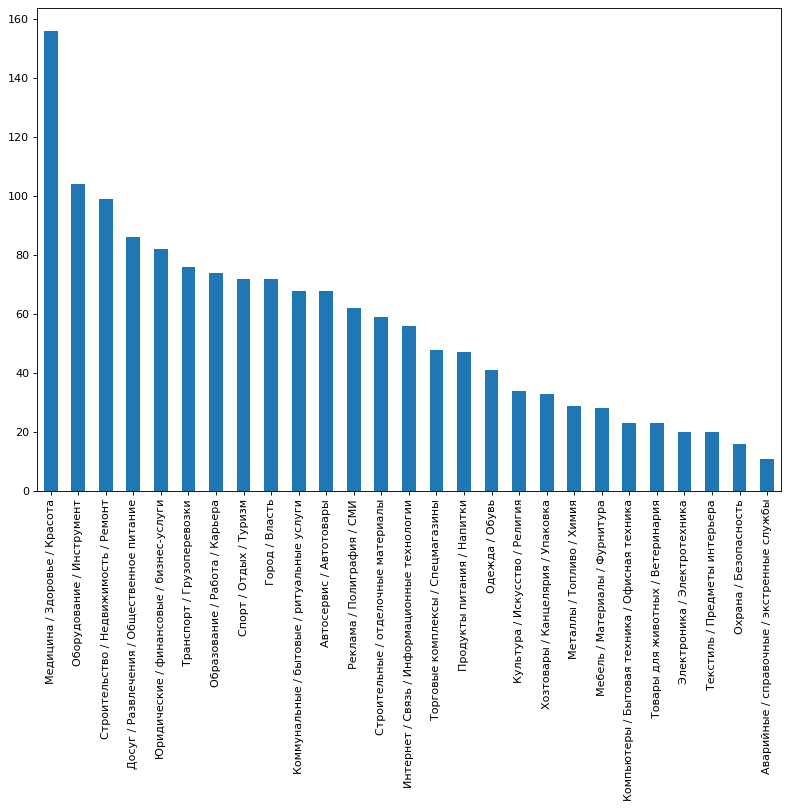

Столбчатая гистограмма данных столбца Рубрика 2го уровня


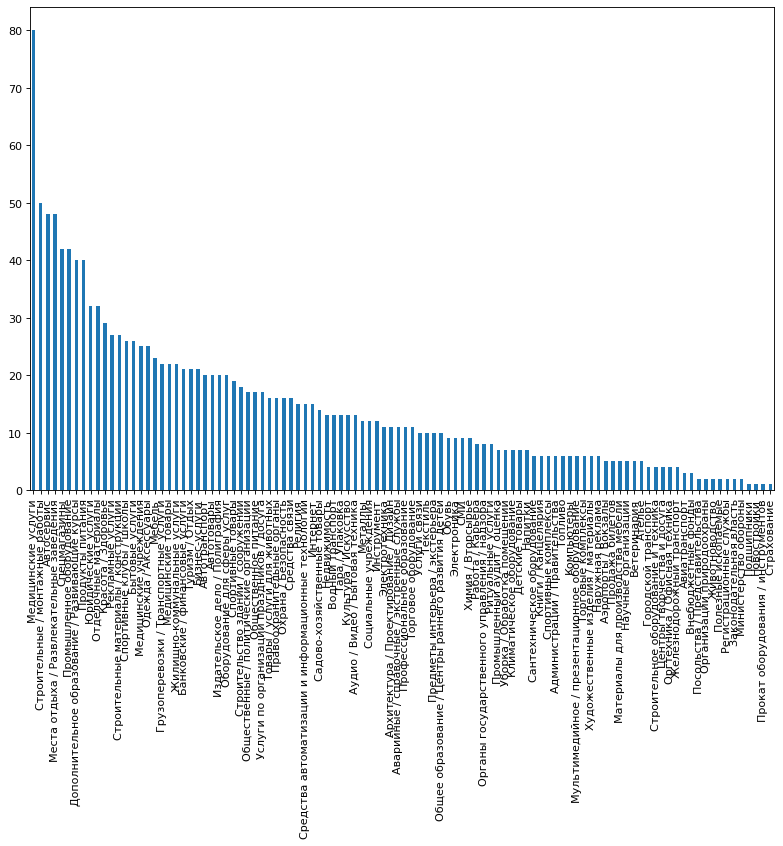

Столбчатая гистограмма данных столбца Категория Пенз область


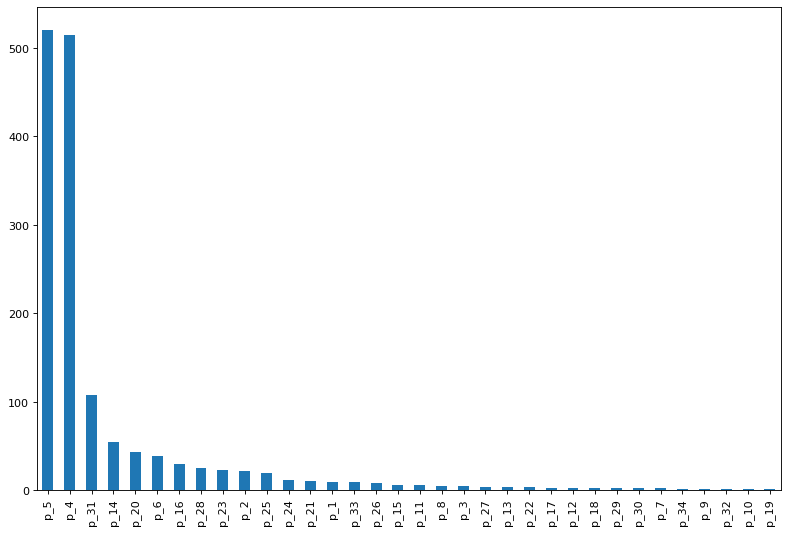

Столбчатая гистограмма данных столбца Категория Лен область


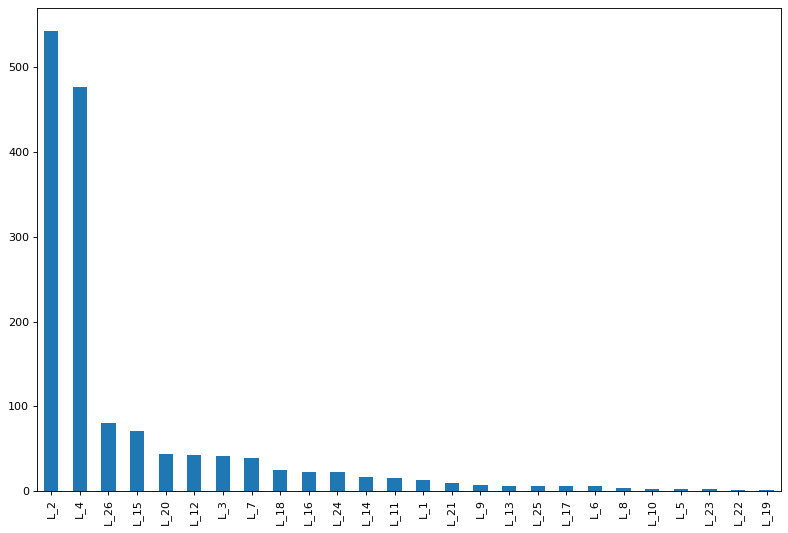

Столбчатая гистограмма данных столбца Категория Респ Бурятия


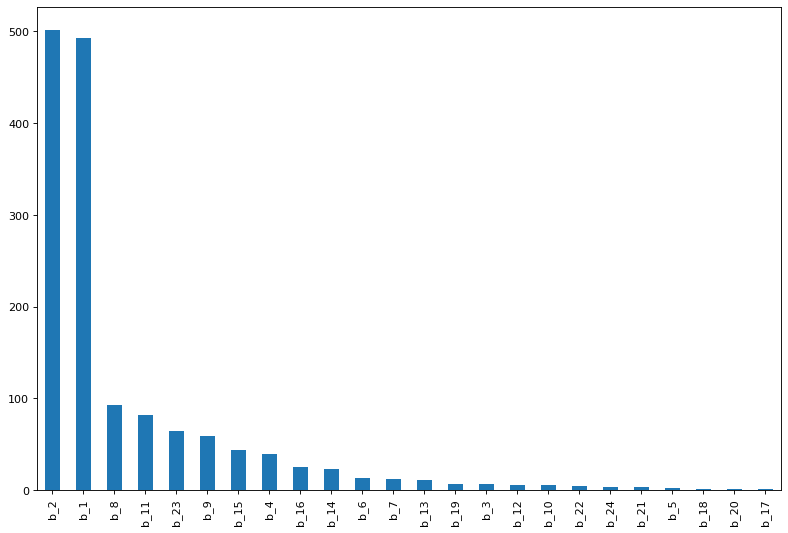

CPU times: user 5.44 s, sys: 567 ms, total: 6.01 s
Wall time: 6.01 s


,Категория,Рубрика 2го уровня,Рубрика,Тематика рубрики,Код рубрики,Ключевые слова,Описание,Категория Пенз область,Категория Лен область,Категория Респ Бурятия
0,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Аварийные службы,Офисные учреждения,122,Аварийка; Аварийная; Аварийная служба; Аварийн...,В данную рубрику следует вносить РАЙОННЫЕ авар...,p_4,L_2,b_1
1,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Ликвидация нефтеразливов / газонефтеводопроявл...,Офисные учреждения,59508,Ликвидация аварийных разливов нефтепродуктов; ...,"В данную рубрику следует вносить организации, ...",p_4,L_2,b_1
2,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Пожарная охрана,Офисные учреждения,143,Пожар; Пожарная служба; Пожарная часть; Пожаро...,В данную рубрику следует вносить районные пожа...,p_4,L_2,b_1
3,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Скорая медицинская помощь,"Больницы, медицина",227,Врач на дом; Вызов врача; Вызов врача на дом; ...,В данную рубрику следует вносить районные подс...,p_31,L_25,b_7
4,Аварийные / справочные / экстренные службы,Аварийные / справочные / экстренные службы,Службы аварийных комиссаров,Офисные учреждения,16182,Аварийные комиссары; Аваркомы; Автокомиссары; ...,В данную рубрику следует вносить службы аварий...,p_4,L_2,b_1


In [5]:
%%time
EDA(df_gis, ['Категория', 'Рубрика 2го уровня', 'Категория Пенз область', 
             'Категория Лен область', 'Категория Респ Бурятия'])

Итак, что можно увидеть:  
1. столбец "Ключевые слова" имеет ряд пропусков.  
2. Среди всех категорий больше всего значений относятся к медицине. На втором месте, с приличным отставанием идёт категория "Оборудование/Инструмент", завершает тройку лидеров "Строительство/Недвижимость/Ремонт". Меньше всего представлены справочные и экстренные службы.  

3. На столбчатой гистограмме для рубрик 2-го уровня (это подуровень категорий) на первом месте всё так же медицинские услуги, далее идут строительные и монтажные работы, а третье место отдано местам отдыха и развлекательным заведениям.  

4. Далее мы выстроили гистограммы для целевых признаков, которые, собственно, необходимо в будущем определить.  
Чтобы определить, что значат эти индексы, откроем поступательно каждый файл и посмотрим:

Функция для среза данных таблиц с нормативами ТКО + доп столбец: подсчет количества строк основного файла, которые относятся к наиболее часто и редко повторяющимся категориям.  
На вход подается:  
- датафрейм субъекта РФ с нормативами ТКО  
- те значения, которые наиболее часто и редко представлены на гистограмме основного файла  
- столбец основного файла (посвящен выбранному субъекту РФ), по которому будет вестись подсчет строк

In [6]:
def query_max_min_count(data, names, name_of_cat):
    data_query = data.query('Код == @names')
    data_query['Количество строк категории в файле 2ГИС'] = [value for key, value 
                        in df_gis[name_of_cat].value_counts().to_dict().items() 
                        for i in data_query['Код'] if i == key]
    return data_query

<ins>Пенза </ins>

In [7]:
penza = pd.read_excel('нормативы ТКО Пенза.xlsx')
penza

,Код,Наименование категории объектов
0,p_1,"Научно-исследовательские, проектные институты ..."
1,p_2,"Банки, финансовые учреждения"
2,p_3,Отделения связи
3,p_4,"Административные, офисные учреждения"
4,p_5,Предприятия торговли
5,p_6,"Автомастерские, шиномонтажная мастерская, стан..."
6,p_7,Автозаправочные станции
7,p_8,Автостоянки и парковки
8,p_9,"Гаражи, парковки закрытого типа"
9,p_10,Автомойка


In [8]:
query_max_min_count(penza, ["p_4", "p_5", "p_32"], 'Категория Пенз область')

,Код,Наименование категории объектов,Количество строк категории в файле 2ГИС
3,p_4,"Административные, офисные учреждения",520
4,p_5,Предприятия торговли,515
31,p_32,"Бани, сауны",1


Итак, для нормативов ТКО Пензенской области первые места занимают категории "Административные, офисные учреждения", второе место - предприятия торговли. Последние 2 столбика на шкале гистограммы - категории "Бани и сауны" и "Иное" (то, что не удалось идентифицировать с файлом  df_gis.

<ins>Ленинградская область </ins>

In [9]:
lenobl = pd.read_excel('нормативы ТКО Лен обл.xlsx')
lenobl

,Код,Наименование категории объектов
0,L_1,Административные учреждения (отдельно стоящие ...
1,L_2,"Офисные учреждения, служебные помещения, банки..."
2,L_3,"Продовольственные магазины, магазины алкогольн..."
3,L_4,"Промтоварные магазины, аптеки"
4,L_5,"Супермаркеты (универмаги), магазины смешанной ..."
5,L_6,Железнодорожные и автовокзалы
6,L_7,"Автомастерские, шиномонтажная мастерская, стан..."
7,L_8,"Автомойки, автозаправочные станции"
8,L_9,"Автостоянки, парковки"
9,L_10,Дошкольные образовательные учреждения


In [10]:
query_max_min_count(lenobl, ["L_2", "L_4", "L_19"], 'Категория Лен область')

,Код,Наименование категории объектов,Количество строк категории в файле 2ГИС
1,L_2,"Офисные учреждения, служебные помещения, банки...",543
3,L_4,"Промтоварные магазины, аптеки",477
18,L_19,"Бани, сауны",1


Первую категорию плохо видно:

In [11]:
lenobl[lenobl['Код'] == 'L_2']['Наименование категории объектов'].to_list()

['Офисные учреждения, служебные помещения, банки (расположенные во встроенных помещениях), конструкторские бюро, научно-исследовательские институты, отделения связи']

Что мы видим: категории схожи, но при этом категория административных учреждений находится отдельно, а перед нами офисные учреждения, к которым также отнесли и архивы, и музеи, и библиотеки. А в Пензенской области, например, библиотекам и архивам принадлежит отдельная категория.  
Точно так же и вторая строчка нашей таблицы: "Промтоварные магазины, аптеки". А что в Пензе? Тут вторую строчку рейтинга занимает категория "Предприятия торговли". Как можно заметить, к предприятиям торговли можно отнести и "Промтоварные магазины" (вторая категория Лен обл), и "аптеки" (она же), и "Супермаркеты (универмаги)..." (пятая категория Лен обл), и "Продовольственные магазины" (тоже отдельная категория Лен области).

<ins>Республика Бурятия </ins>

In [12]:
burya = pd.read_excel('нормативы ТКО Бурятия.xlsx')
burya

,Код,Наименование категории объектов
0,b_1,"научно-исследовательские, проектные институты ..."
1,b_2,"продовольственные магазины, промтоварные магаз..."
2,b_3,"супермаркеты (универмаги), рынки продовольстве..."
3,b_4,"автомастерские, шиномонтажные мастерские, стан..."
4,b_5,автозаправочные станции
5,b_6,"железнодорожные и автовокзалы, аэропорты, речн..."
6,b_7,"больницы, санатории, пансионаты, курорты, проф..."
7,b_8,"поликлиники, фармацевтические организации, сто..."
8,b_9,"дошкольные образовательные учреждения, общеобр..."
9,b_10,"детские дома, интернаты"


In [13]:
query_max_min_count(burya, ["b_2", "b_1","b_17"], 'Категория Респ Бурятия')

,Код,Наименование категории объектов,Количество строк категории в файле 2ГИС
0,b_1,"научно-исследовательские, проектные институты ...",501
1,b_2,"продовольственные магазины, промтоварные магаз...",492
16,b_17,"бани, сауны",1


In [14]:
print(burya[burya['Код'] == 'b_1']['Наименование категории объектов'].to_list())
print()
print(burya[burya['Код'] == 'b_2']['Наименование категории объектов'].to_list())

['научно-исследовательские, проектные институты и конструкторские бюро, банки, финансовые учреждения, административные, офисные учреждения (включая частные охранные организации), отделения связи']

['продовольственные магазины, промтоварные магазины, павильоны торговые (продовольственные, непродовольственные), лотки, палатки, киоски']


___________________________________________________________________________________________________________________
Что касается республики Бурятия: в первую категорию помимо НИОКБ отнесены банки и отделения связи.  
Сравним с другими нормативами: 
- в Пензенской области для отделения связи заведена отдельная категория, для банков - тоже. 
- в Лен области банки относят к офисным учреждениям, а отделений связи вообще нет (соответственно, тут может быть только субъективная оценка: либо отнести всё же к офисам, либо вообще к категории "Иное").  

Категория, посвященная сфере торговли, развернуто описана. Видно, что в неё войдут практически все предприятия торговли за исключением рынков и супермаркетов.  
А в Лен области, например, более мелкое деление: для предприятий торговли выделены аж 3 категории.  
Что касается Пензенской области: предприятия торговли все принадлежат к одной категории, при этом никакой расшифровки (что туда относится) внутри нет.

___________________________________________________________________________________________________________________
Таким образом, мы определили, что для решения данной задачи вряд ли подойдет готовый алгоритм вычисления расстояний между текстами, т.к. явных вариаций для разделения нет. Соответственно, решать задачу будем посредством машинного обучения.

Переходим к предобработке данных:

<ins>Работа с пропусками </ins>

Как мы помним, в основном файле пропуски были только в одном столбце:

In [15]:
df_gis['Ключевые слова'].isna().sum()

19

In [16]:
df_gis[df_gis['Ключевые слова'].isna() == True]

,Категория,Рубрика 2го уровня,Рубрика,Тематика рубрики,Код рубрики,Ключевые слова,Описание,Категория Пенз область,Категория Лен область,Категория Респ Бурятия
93,Город / Власть,Общественные / политические организации,Венчурные фонды,Офисные учреждения,112417,NaN,Вносить Венчурные фонды. Венчурный фонд - риск...,p_4,L_2,b_1
94,Город / Власть,Общественные / политические организации,Гарантийные фонды,Офисные учреждения,112416,NaN,Вносить Гарантийные фонды. Также данные органи...,p_4,L_2,b_1
96,Город / Власть,Общественные / политические организации,Гранты,Офисные учреждения,733,NaN,"В данную рубрику следует вносить организации, ...",p_4,L_2,b_1
97,Город / Власть,Общественные / политические организации,Залоговые фонды,Офисные учреждения,112415,NaN,Вносить Залоговые фонды. Залоговый фонд - это ...,p_4,L_2,b_1
102,Город / Власть,Общественные / политические организации,Общественные группы,Офисные учреждения,110878,NaN,Вносить общественные группы с некоммерческой н...,p_4,L_2,b_1
106,Город / Власть,Общественные / политические организации,Приёмные Президента,Офисные учреждения,110949,NaN,В данную рубрику следует вносить приемные През...,p_4,L_2,b_1
139,Город / Власть,Социальные учреждения,Бэби-боксы,"Детские дома, интернаты",110322,NaN,В данную рубрику следует вносить бэби-боксы. \...,p_15,L_13,b_10
167,Досуг / Развлечения / Общественное питание,Места отдыха / Развлекательные заведения,Заповедники,Ботанические сады,112594,NaN,"Вносить заповедники, которые открыты для посещ...",p_21,L_15,b_24
240,Интернет / Связь / Информационные технологии,Интернет,Интернет-провайдеры,Офисные учреждения,176,NaN,"Вносить интернет-провайдеры, которые предостав...",p_4,L_2,b_1
332,Коммунальные / бытовые / ритуальные услуги,Жилищно-коммунальные услуги,Инженерные службы,Офисные учреждения,49532,NaN,В данную рубрику следует вносить инженерные сл...,p_4,L_2,b_1


Поскольку удалять данные нам ни в коем случае нельзя, а столбец предполагается значимым для модели (что мы проверим несколько позже), пропуски мы будем заполнять.  
Для этого посмотрим, какие ключевые слова:

In [17]:
df_gis['Ключевые слова'][1000:1005]

1000    Аренда парусных яхт; Аренда яхт; Парусный спор...
1001    Аренда баскетбольных залов; Аренда баскетбольн...
1002    Басеин; Бассейн для грудничков; Бассейн для де...
1003    Аренда лошадей; Верховая езда; Иподром; Ипподр...
1004    Аренда катка; Городской каток; Катание на конь...
Name: Ключевые слова, dtype: object

In [18]:
df_gis[1000:1005]

,Категория,Рубрика 2го уровня,Рубрика,Тематика рубрики,Код рубрики,Ключевые слова,Описание,Категория Пенз область,Категория Лен область,Категория Респ Бурятия
1000,Спорт / Отдых / Туризм,Спортивные клубы / школы,Яхт-клубы,Спортивные клубы,9965,Аренда парусных яхт; Аренда яхт; Парусный спор...,Вносить яхт-клубы. Яхт-клубы могут предоставит...,p_20,L_15,b_11
1001,Спорт / Отдых / Туризм,Спортивные комплексы,Аренда спортивных площадок,Спортивные клубы,110498,Аренда баскетбольных залов; Аренда баскетбольн...,"В данную рубрику вносить организации, которые ...",p_20,L_15,b_11
1002,Спорт / Отдых / Туризм,Спортивные комплексы,Бассейны,Спортивные клубы,261,Басеин; Бассейн для грудничков; Бассейн для де...,Вносить плавательные бассейны общего посещения...,p_20,L_15,b_11
1003,Спорт / Отдых / Туризм,Спортивные комплексы,Конные клубы / Ипподромы,Спортивные клубы,262,Аренда лошадей; Верховая езда; Иподром; Ипподр...,В данную рубрику следует вносить специально от...,p_20,L_15,b_11
1004,Спорт / Отдых / Туризм,Спортивные комплексы,Ледовые дворцы / Катки,Спортивные клубы,11974,Аренда катка; Городской каток; Катание на конь...,В данную рубрику следует вносить администрации...,p_20,L_15,b_11


Получается, ключевые слова раскрывают, какие именно виды деятельности компаний относятся к той или иной рубрике.  
Что бросается в глаза: столбец "Ключевые слова" отчасти включает в себя данные столбца "Рубрика". Поэтому для отсутствующих значений мы можем заполнить пропуски, взяв информацию из столбца "Рубрика".

In [19]:
df_gis['Ключевые слова'] = np.where(df_gis['Ключевые слова'].isna(), df_gis['Рубрика'], df_gis['Ключевые слова'])

In [20]:
df_gis['Ключевые слова'].isna().sum()

0

Идем дальше.  
Сделаем предобработку данных, формируя векторы моделью BERT.  
Для этого оставим лишь один столбец - "Ключевые слова", поскольку именно он содержит бо́льшую информативность.

In [21]:
def clear_text(text):     # очистим строки при помощи регулярных выражений: оставим только буквы.
    new_text = (re.sub(r'[^а-яА-Я]', ' ', text)).lower()
    return " ".join(new_text.split())

В качестве признаков со стороны рубрик возьмем столбец "Тематика рубрики":

Очищаем столбец от лишних знаков и запускаем препроцессинг:

In [22]:
all_t = [clear_text(i) for i in df_gis['Тематика рубрики']]
df_gis['Тематика рубрики без знаков'] = all_t

In [23]:
penz = [clear_text(i) for i in penza['Наименование категории объектов']]
penz[:2]

['научно исследовательские проектные институты и конструкторские бюро',
 'банки финансовые учреждения']

In [24]:
penza['Чистые нормативы'] = penz

Теперь напишем функцию вычисления косинусного сходства текстов. На вход будут подаваться 2 массива (наши векторные представления текстов), на выходе будет максимальная вероятность:

In [25]:
def cosine_sim_vectors(array1, array2):
    lst_key_array1 = []   # ключи первого массива
    lst_prob = []
    for i in range(len(array1)):
        prob = []
        for j in range(len(array2)):   # сравниваем 2 вектора в цикле
            vec1 = array1[i].reshape(1, -1)
            vec2 = array2[j].reshape(1, -1)
            
            prob.append(cosine_similarity(vec1, vec2)[0][0]) # вычисляем косинусное расстояние
            
        lst_key_array1.append(df_gis.loc[i, 'Рубрика'])  
        lst_prob.append(prob) # сохраняем все вероятности сходства для каждого индекса массива1 и массива2        
  
    lst_max_proba = [max(lst_prob[p]) for p in range(len(lst_prob))] # выбираем максимальную вероятность
    lst_index_array2 = [penza.loc[lst_prob[p].index(max(lst_prob[p])), 
                                  'Наименование категории объектов'] for p in range(len(lst_prob))]
    
    return lst_key_array1, lst_index_array2, lst_max_proba
    # возвращаем ключи массива1, нормативы массива2 и максимальную вероятность

Идем дальше: сделаем векторизацию при помощи TF-IDF. Для этого подготовим данные:

In [26]:
def lemmatize(text):      # лемматизируем текст и объединим элементы списка в строку, которую получим на выходе
    m = Mystem()
    lemm_text = []
    for row in text:
        lemmas = ' '.join(m.lemmatize(row))
        lemm_text.append(lemmas.split())
    return lemm_text


def clear_text(text):     # очистим строки при помощи регулярных выражений: оставим только буквы.
    new_text = (re.sub(r'[^а-яА-Я]', ' ', text)).lower()
    return " ".join(new_text.split())

def sentences(text):    # разделим на предложения, попутно очищая текст от знаков и преобразуя его к нижнему регистру
    try:
        return [clear_text(sent) for sent in ru_sent_tokenize(text)]
    except:
        return []

from nltk.corpus import stopwords
stopwords = stopwords.words('russian') + ['-', 'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 'г', 'Добрый день', 'Здравствуйте', 'доброго', 'дня', 'добрый', 'день', 'здравствуйте', 'В', 'тут-то', 'было', 'На', 'чуть-чуть', 'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'Как', 'без', 'рэ']


def remove_stopwords(sentences, stopwords = stopwords): # уберем стоп-слова
    try:
        out = []
        for sentence in sentences:
            out.append(" ".join([token for token in sentence.split() if not token in stopwords]))
        return out
    except:
        return []

stoplemmas = ['день', 'данный', 'который', 'ваш', 'свой', 'месяц', 'какой', 'сей', 'наш', 'мочь']


def remove_stoplemmas(sentences):  # уберем стоп-леммы
    res = []
    if len(sentences) > 0:
        res.append([lemma for lemma in sentences if not lemma in stoplemmas])
    return res

def preprocessing(text):     # вызовем все функции в одной
    sents = sentences(text)
    no_stopwords = remove_stopwords(sents)
    lemmas = lemmatize(no_stopwords)
    no_stoplemmas = remove_stoplemmas(lemmas)
    flat_lemmas = [x for sentence in no_stoplemmas for sublist in sentence for x in sublist]
    return flat_lemmas

Теперь предобработаем столбец "Все категории без знаков":

In [27]:
%%time
df_gis['Тематика_лемма'] = df_gis['Тематика рубрики без знаков'].progress_apply(preprocessing)

my bar!: 100%|██████████| 1507/1507 [20:34<00:00,  1.22it/s]       

CPU times: user 3.13 s, sys: 12.9 s, total: 16.1 s
Wall time: 20min 34s


In [28]:
%%time
penza['Нормативы_лемма'] = penza['Наименование категории объектов'].progress_apply(preprocessing)

my bar!: 100%|██████████| 43/43 [00:35<00:00,  1.22it/s]

CPU times: user 115 ms, sys: 395 ms, total: 510 ms
Wall time: 35.3 s


In [29]:
corpus_1 = [" ".join(x) for x in df_gis['Тематика_лемма']]
corpus_2 = [" ".join(x) for x in penza['Нормативы_лемма']]

In [30]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /home/dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
voc = TfidfVectorizer(stop_words=stopwords).fit(corpus_1)
feat_1 = voc.transform(corpus_1)
feat_2 = voc.transform(corpus_2)

И косинус угла:

In [32]:
%%time
keys, norms, sim = cosine_sim_vectors(feat_1.toarray(), feat_2.toarray())

CPU times: user 27.8 s, sys: 11.8 ms, total: 27.8 s
Wall time: 27.8 s


In [33]:
data_tfidf = pd.DataFrame()
data_tfidf['themes'], data_tfidf['norms'], data_tfidf['sim'] = keys, norms, sim
data_tfidf

,themes,norms,sim
0,Аварийные службы,Общеобразовательное учреждение,0.684546
1,Ликвидация нефтеразливов / газонефтеводопроявл...,Общеобразовательное учреждение,0.684546
2,Пожарная охрана,Общеобразовательное учреждение,0.684546
3,Скорая медицинская помощь,Медицина,0.536056
4,Службы аварийных комиссаров,Общеобразовательное учреждение,0.684546
...,...,...,...
1502,Услуги медиаторов,Общеобразовательное учреждение,0.684546
1503,Экспертиза авиационных происшествий,Общеобразовательное учреждение,0.684546
1504,Экспертиза лекарственных средств,Общеобразовательное учреждение,0.684546
1505,Экспертиза товаров народного потребления,Общеобразовательное учреждение,0.684546


In [34]:
pred_tfidf = []
for i in range(len(data_tfidf)):
    for j in range(len(penza)):
        if data_tfidf.loc[i, 'norms'] == penza.loc[j, 'Наименование категории объектов']:
            pred_tfidf.append(penza.loc[j, 'Код'])

In [35]:
from sklearn.metrics import f1_score

f1_score(df_gis['Категория Пенз область'], pred_tfidf, average='micro')

0.424699402786994

Меньше половины.

Теперь напишем функцию, где инициализируем модель Doc2Vec:

In [36]:
def build_model(max_epochs, vec_size, alpha, tagged_data):
    
    model = Doc2Vec(vector_size=vec_size,
               alpha=alpha,
               min_alpha=0.00025,
               min_count=1,
               dm=1)
    
    model.build_vocab(tagged_data)
       
    for epoch in range(max_epochs):   # потренируем модель
        print(f"Iteration {epoch}")
        model.train(tag_data,
                   total_examples=model.corpus_count,
                   epochs=model.epochs)        

        model.alpha -= 0.0002   # снижаем learning rate 

        model.min_alpha = model.alpha   
    
    model.save("DOCS_w2v_MODEL.model")  # сохраняем модель до востребования
    print("Model Saved")
    return model

Переводим столбец с категориями в формат TaggedDocument, чтобы модель могла обучиться на них:

In [37]:
tag_data_1 = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(df_gis['Тематика_лемма'])]
tag_data_2 = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(penza['Нормативы_лемма'])]
tag_data = tag_data_1 + tag_data_2

In [38]:
tag_data[:5], tag_data[-5:]

([TaggedDocument(words=['офисный', 'учреждение'], tags=['0']),
  TaggedDocument(words=['офисный', 'учреждение'], tags=['1']),
  TaggedDocument(words=['офисный', 'учреждение'], tags=['2']),
  TaggedDocument(words=['больница', 'медицина'], tags=['3']),
  TaggedDocument(words=['офисный', 'учреждение'], tags=['4'])],
 [TaggedDocument(words=['индивидуальный', 'жилой', 'дом', 'пенза'], tags=['38']),
  TaggedDocument(words=['индивидуальный', 'жилой', 'дом', 'кузнецк', 'зато', 'заречный'], tags=['39']),
  TaggedDocument(words=['индивидуальный', 'жилой', 'дом', 'муниципальный', 'образование', 'население', 'чело'], tags=['40']),
  TaggedDocument(words=['индивидуальный', 'жилой', 'дом', 'муниципальный', 'образование', 'население', 'чело'], tags=['41']),
  TaggedDocument(words=['иной'], tags=['42'])])

Запускаем функцию:

In [39]:
doc2vec = build_model(max_epochs=100, vec_size=15, alpha=0.025, tagged_data=tag_data)

Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

Модель обучилась. Проверим:

In [40]:
doc2vec.wv.similar_by_word("медицина")

[('обувь', 0.6962112188339233),
 ('магазин', 0.6511425375938416),
 ('питание', 0.6417560577392578),
 ('салон', 0.6255432367324829),
 ('отделение', 0.5901955366134644),
 ('медицинский', 0.5708369612693787),
 ('интернат', 0.565756618976593),
 ('клиника', 0.5585362911224365),
 ('пенза', 0.5508756041526794),
 ('риутальный', 0.5420202016830444)]

In [41]:
doc2vec.wv.similar_by_word("банк")

[('дополнительный', 0.6839833855628967),
 ('обслуживание', 0.6573476791381836),
 ('иной', 0.6470200419425964),
 ('автозаправочный', 0.6433500051498413),
 ('магазин', 0.6188270449638367),
 ('промтовары', 0.6180785894393921),
 ('технический', 0.6080384850502014),
 ('ремноты', 0.6025703549385071),
 ('высокий', 0.5902696847915649),
 ('осуществлять', 0.5835429430007935)]

Всё работает. Проверим на словосочетаниях (возведем их в инфинитив, т.к. модель обучилась на лемматизированных словах):

In [42]:
doc2vec.wv.n_similarity(('детский интернат').split(), ('школа интернат').split())

0.6854299

In [43]:
doc2vec.wv.n_similarity(('услуга кладбище').split(), ('ритуальный услуга').split())

0.31729662

In [44]:
doc2vec.wv.n_similarity(('банк офисный').split(), ('финансовый услуга').split())

0.624896

In [45]:
doc2vec.wv.n_similarity(('цирк концертный зал').split(), ('многоквартирный дом').split())

0.1707685

Да, всё работает. Запустим теперь для наших данных:

In [46]:
def similar_by_doc2vec(sent1, sent2, mod_name):
    lst_cat_sent1 = []   # категории первого массива
    lst_prob = []
    for i in range(len(sent1)):
        prob = []
        for j in range(len(sent2)):   # сравниваем 2 вектора в цикле
            prob.append(mod_name.wv.n_similarity(sent1[i], sent2[j])) # вычисляем косинусное расстояние
            
        lst_cat_sent1.append(df_gis.loc[i, 'Рубрика'])  
        lst_prob.append(prob) # сохраняем все вероятности сходства для каждого индекса текста1 и текста2        
  
    lst_max_proba = [max(lst_prob[p]) for p in range(len(lst_prob))] # выбираем максимальную вероятность
    lst_index_sent2 = [penza.loc[lst_prob[p].index(max(lst_prob[p])), 
                                  'Наименование категории объектов'] for p in range(len(lst_prob))]
    
    return lst_cat_sent1, lst_index_sent2, lst_max_proba
#     возвращаем ключи массива1, нормативы массива2 и максимальную вероятность

In [47]:
%%time
data_d2v = pd.DataFrame()
data_d2v['index_array1'], data_d2v['index_array2'], data_d2v['probability'] = similar_by_doc2vec(df_gis['Тематика_лемма'], penza['Нормативы_лемма'], doc2vec)

CPU times: user 9.17 s, sys: 310 µs, total: 9.17 s
Wall time: 9.17 s


In [48]:
data_d2v[data_d2v['probability'] > 0.90]

,index_array1,index_array2,probability
0,Аварийные службы,"Административные, офисные учреждения",0.946555
1,Ликвидация нефтеразливов / газонефтеводопроявл...,"Административные, офисные учреждения",0.946555
2,Пожарная охрана,"Административные, офисные учреждения",0.946555
3,Скорая медицинская помощь,Медицина,0.909297
4,Службы аварийных комиссаров,"Административные, офисные учреждения",0.946555
...,...,...,...
1502,Услуги медиаторов,"Административные, офисные учреждения",0.946555
1503,Экспертиза авиационных происшествий,"Административные, офисные учреждения",0.946555
1504,Экспертиза лекарственных средств,"Административные, офисные учреждения",0.946555
1505,Экспертиза товаров народного потребления,"Административные, офисные учреждения",0.946555


Похоже на правду.

Посчитаем коэффициент:

In [49]:
predict = []

for i in range(len(data_d2v)):
    for j in range(len(penza)):
        if data_d2v.loc[i, 'index_array2'] == penza.loc[j, 'Наименование категории объектов']:
            predict.append(penza.loc[j, 'Код'])

In [50]:
from sklearn.metrics import f1_score

f1_score(df_gis['Категория Пенз область'], predict, average='micro')

0.5103251493032515

Результат чуть выше среднего.

Выбираем BERT.